In [2]:
naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_transbench101_micro'

In [3]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [4]:
dataset = 'autoencoder'
proxy = 'nwot'
data = dfs[dataset]

In [5]:
import os

bench_dir = os.path.join(naslib_path, f'naslib/data/zc_benchmarks/{proxy}')
score_files = [p for p in os.listdir(bench_dir) if 'trans' in p and 'norm' in p]
score_files

['benchmark--no_norm--relu--transbench101_micro--class_scene--0.json',
 'benchmark--normalize--relu--transbench101_micro--class_scene--0.json']

In [6]:
import json
import os

new_score_file = score_files[1]

with open(os.path.join(bench_dir, new_score_file), 'r') as f:
    new_data = json.load(f)

In [7]:
from zc_combine.fixes.utils import read_new_score

read_new_score(data, new_data, proxy, copy_old_column=False)

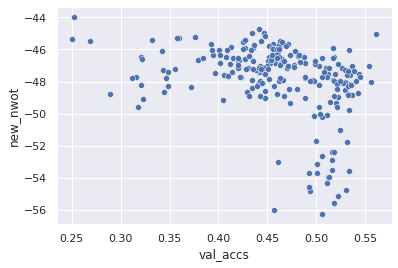

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

prox = f'new_{proxy}'
plot_data = data[(data[prox] > -1e8) & (data[prox] < 0)].copy()

sns.scatterplot(data=plot_data, x='val_accs', y=prox)
#plt.xlim(70, 91)
#plt.ylim(-1, 300)
#plt_ylim(proxy)
plt.show()

In [9]:
plot_data[['net', 'val_accs', 'new_nwot']]

,net,val_accs,new_nwot
0,"(2, 3, 2, 3, 2, 3)",0.456316,-45.862148
1,"(3, 1, 1, 2, 1, 2)",0.451898,-46.467653
2,"(0, 0, 2, 1, 2, 3)",0.515741,-52.915036
3,"(3, 3, 3, 3, 0, 0)",0.440002,-48.169514
4,"(2, 1, 0, 1, 3, 0)",0.525916,-47.153451
...,...,...,...
236,"(0, 2, 1, 1, 2, 1)",0.521295,-49.604573
237,"(1, 1, 1, 2, 3, 3)",0.459897,-46.561328
238,"(1, 3, 0, 2, 3, 0)",0.467537,-46.735434
239,"(2, 0, 0, 1, 0, 2)",0.513043,-53.919740


In [10]:
from zc_combine.fixes.operations import parse_ops_nb201, count_all_ops

count_set = {0, 1, 2, 3}
ops = parse_ops_nb201(plot_data)
count_all_ops(plot_data, ops, count_set)

In [11]:
# TNB101_micro op names and edge indices to edges for convenience
# Op indices for zero and identity are 0, 1, in NB201 they are 1, 0
OP_NAMES = ["Zero", "Identity", "ReLUConvBN3x3", "ReLUConvBN1x1", "AvgPool1x1"]
OP_NAMES_NB201 = ['none', 'skip_connect', 'nor_conv_3x3', 'nor_conv_1x1', 'avg_pool_3x3']

EDGE_LIST = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))

## NASWOT bias
NASWOT seems to be highly biased towards the number of convolutions. Let us define `count` == number of `Conv3x3` + number of `Conv1x1` in a cell.

Then, plotting every count (from 1 to 6) as a different colour, we get this:

In [24]:
from zc_combine.fixes.operations import get_ops_edges_tnb101
from zc_combine.fixes.utils import nb201_default_isomorphic_cell

op_names, edge_map = get_ops_edges_tnb101()
nb201_default_isomorphic_cell(data, edge_map, zero_op=0)

In [30]:
ok_data = data[data['new_net'] == data['net']].copy()
len(ok_data), len(data)

(2128, 4096)

In [31]:
from zc_combine.fixes.operations import parse_ops_nb201, count_all_ops

count_set = {0, 1, 2, 3, 4}
ops = parse_ops_nb201(ok_data)
count_all_ops(ok_data, ops, count_set)

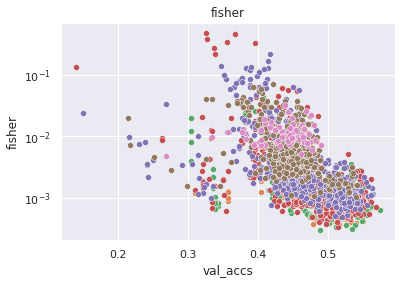

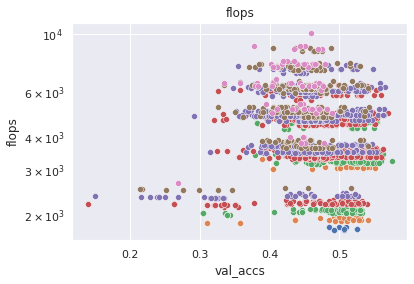

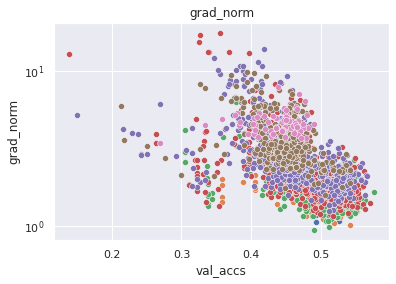

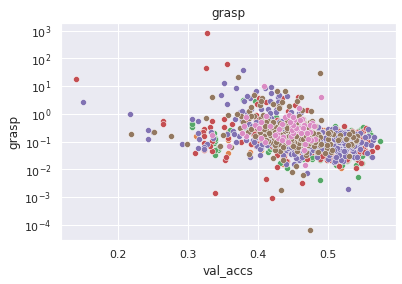

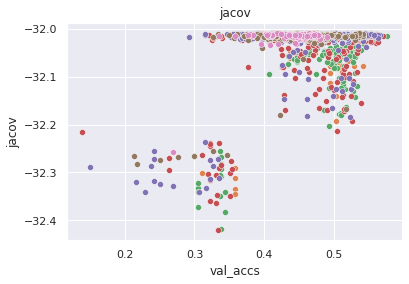

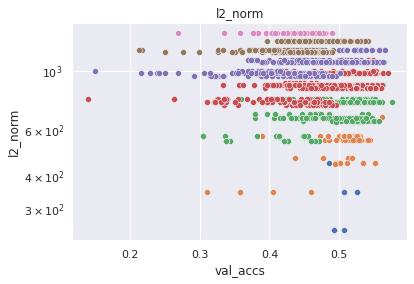

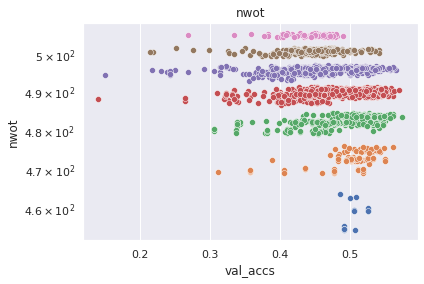

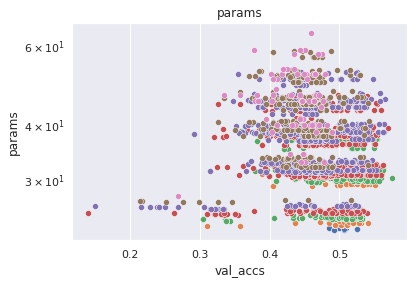

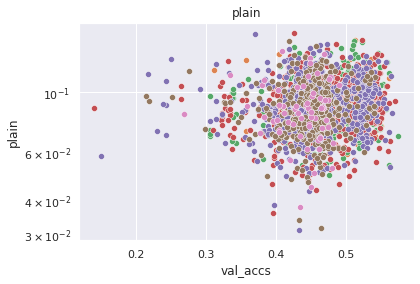

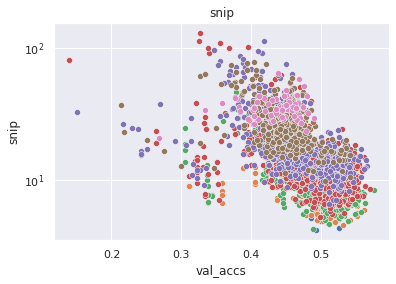

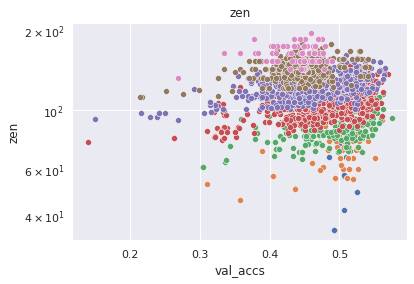

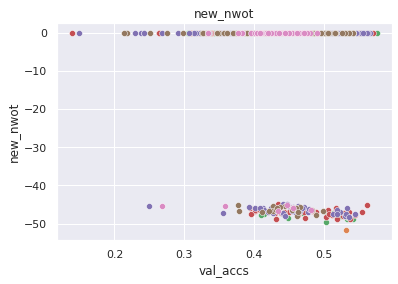

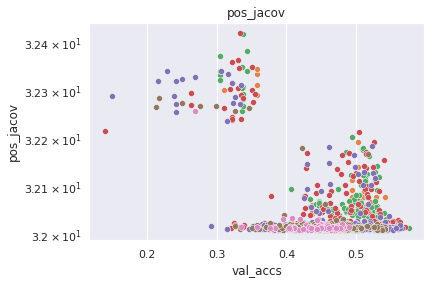

In [36]:
from zc_combine.fixes.operations import plot_clouds

proxdir = 'plots_zcs'
#os.mkdir(proxdir)

ok_data['pos_jacov'] = -ok_data['jacov']

for p in ok_data.columns:
    if p in ['new_net', 'net', 'val_accs', 'rank', 'random'] or '(' in p:
        continue

    d = ok_data[ok_data[p] > -1e8]
    d = d[d['val_accs'] > 0.1]

    plot_clouds(d, (2, 3), p, vmax=7)
    plt.title(p)
    #plt.ylim(-32.8, -31.8)
    #plt.xlim(40, 45)
    #plt.ylim(680, 695)
    #plt.savefig(os.path.join(proxdir, f'{p}_{dataset}.png'))
    if any(d[p] > 0):
        plt.yscale('log')
    plt.show()

In [15]:
def get_column_stats(d):
    d = d[[c for c in data.columns if '(' in c]]
    return d.describe().loc['mean']

In [16]:
plot_data[plot_data['val_accs'] > 40][['new_net', 'val_accs']]

KeyError: "['new_net'] not in index"

In [17]:
import pandas as pd

d1 = data[data['val_accs'] < 29]
d2 = data[(data['val_accs'] > 29) & (data['val_accs'] < 39)]
d3 = data[data['val_accs'] > 39]

pd.DataFrame({k: get_column_stats(v) for k, v in zip(['d1', 'd2', 'd3'], [d1, d2, d3])})

ValueError: Cannot describe a DataFrame without columns

In [18]:
ok_data

,net,val_accs,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,zen,epe_nas,synflow,random,rank,new_nwot,new_net
0,"(2, 3, 2, 3, 2, 3)",42.759754,4.458780,4662.880768,74.508804,-2.955261,-32.010446,1265.389038,500.717764,22.391940,0.066559,656.970154,140.918808,451.375314,108.596648,1196,1432.0,-45.862148,"(2, 3, 2, 3, 2, 3)"
1,"(3, 1, 1, 2, 1, 2)",42.316879,0.685677,1719.888384,20.240038,-0.260801,-32.011969,730.687561,482.160494,7.911300,0.054861,179.962784,80.168358,838.104942,80.325202,2254,1945.0,-46.467653,"(3, 1, 1, 2, 1, 2)"
6,"(2, 1, 1, 3, 2, 3)",42.187500,1.369568,3232.393728,35.011379,0.639004,-32.009180,948.673401,489.361654,15.584132,-0.020100,334.091278,105.183723,616.829033,84.024537,1087,2062.0,-45.799991,"(2, 1, 1, 3, 2, 3)"
7,"(3, 1, 2, 3, 2, 3)",43.018513,2.688825,4543.572480,49.950260,-0.832909,-32.008677,1167.675537,495.204769,21.880708,0.079452,478.317688,129.824265,645.470409,117.901912,2747,1069.0,-46.878704,"(3, 1, 2, 3, 2, 3)"
8,"(1, 3, 2, 2, 3, 1)",42.884155,0.983409,3232.393728,26.839363,-0.445370,-32.010736,948.994263,489.355263,15.584132,0.058328,254.557281,111.178154,684.681951,67.328926,3551,1242.5,-45.867380,"(1, 3, 2, 2, 3, 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4087,"(3, 2, 0, 3, 3, 3)",42.242237,3.659826,5834.729984,60.257870,-0.928009,-32.013377,1046.493042,495.191931,28.350596,0.116950,571.500549,133.915222,615.205833,92.048516,491,2012.0,0.000000,"(3, 2, 0, 3, 3, 3)"
4089,"(1, 0, 2, 2, 3, 1)",42.829418,0.596698,1946.151424,18.410036,-0.117420,-32.013806,751.383606,480.521297,9.459588,0.028766,170.491150,78.218185,561.828187,63.918596,2189,1334.5,0.000000,"(1, 0, 2, 2, 3, 1)"
4090,"(3, 3, 3, 1, 0, 2)",44.153065,0.909518,4373.244416,30.881533,-0.187820,-32.012418,948.201050,489.694640,21.023620,0.055849,299.446136,113.669861,572.671152,117.801916,706,124.0,0.000000,"(3, 3, 3, 1, 0, 2)"
4091,"(1, 3, 1, 2, 0, 3)",42.819466,0.611565,3062.065664,21.564592,-0.168459,-32.011389,730.529236,482.606920,14.727044,-0.008370,193.672592,85.900841,741.089293,90.366001,1572,1353.5,0.000000,"(1, 3, 1, 2, 0, 3)"


Let us zoom on a cloud, let's say `count` == 4 (red if plotting from `count` == 1).

Then, the clouds don't seem to depend on the number of `Conv3x3`.

But, accuracy seems to depend on it a bit!

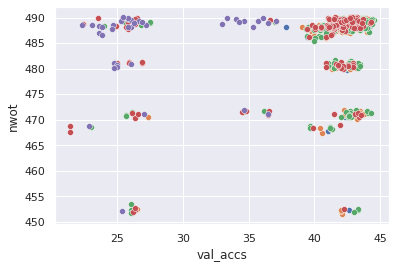

In [16]:
zoom = 4

data_zoom = ok_data[ok_data[str((2, 3))] == zoom]
plot_clouds(data_zoom, data_zoom[str((2,))], proxy, vmax=7)
#plt.xlim(69, 93)
#plt.ylim(700, 820)
plt.show()

Similar to NAS-Bench-201, there is some regularity in different score values:
- nets in the lowest cluster have inactive edges (1,2) and (1,3)
- nets in the second lowest cluster have inactive edge (1,2)
- nets in the second highest cluster have either inactive edge (1,2) and no other inactive, or have inactive both (1,3) and (1,4)
- nets in the highest cluster never have the highest edge inactive

In [42]:
import numpy as np
from zc_combine.fixes.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb201(df)
    return np.array(ops)

ops_0 = get_op_array(filter_by_range(data_zoom, proxy, 450, 465))
ops_1 = get_op_array(filter_by_range(data_zoom, proxy, 465, 475))
ops_2 = get_op_array(filter_by_range(data_zoom, proxy, 475, 483))
ops_3 = get_op_array(filter_by_range(data_zoom, proxy, 483, 500))

In [44]:
np.unique(ops_0[:, 0]), np.unique(ops_0[:, 1])

(array([0]), array([0]))

In [26]:
np.unique(ops_1[:, 0]), np.unique(ops_1[:, 1])

(array([0]), array([1, 2, 3]))

In [35]:
ops_2[ops_2[:, 0] != 0]

array([[3, 0, 0, 2, 3, 2],
       [2, 0, 0, 3, 2, 2],
       [3, 0, 0, 3, 3, 2],
       [3, 0, 0, 2, 3, 3],
       [2, 0, 0, 3, 3, 2],
       [2, 0, 0, 2, 2, 3],
       [2, 0, 0, 3, 2, 3],
       [3, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 2, 2],
       [2, 0, 0, 2, 3, 3],
       [3, 0, 0, 3, 3, 3],
       [2, 0, 0, 3, 3, 3],
       [2, 0, 0, 2, 3, 2],
       [3, 0, 0, 3, 2, 2],
       [3, 0, 0, 2, 2, 3],
       [3, 0, 0, 3, 2, 3]])

In [27]:
np.unique(ops_2[:, 0]), np.unique(ops_2[:, 1])

(array([0, 2, 3]), array([0, 2, 3]))

In [28]:
np.unique(ops_3[:, 0]), np.unique(ops_3[:, 1])

(array([1, 2, 3]), array([0, 1, 2, 3]))

## Conclusion
NASWOT score has problems on other datasets than CIFAR-10 as well.